# Week 1 Lab: next generation sequencing and mutation hunting

## Part 2 (50 pts total)

**Due: Sunday 4/11/21 11:59pm**

Skills covered: More UNIX commands, python scripting, variant calling, error sources

In this lab we'll dig into the sequence alignments we generated last time to identify potential mutations that occurred in the patient but not eiter of her parents.

## 1. Preparing for SNP calling: pileup files

The goal now is to go through our data, and for each position in the reference genome, see how many reads have a mutation at the same position. The SAM file is inconvenient for this, because the reads aren’t matched with the reference in a simple way (though they do contain all the information needed). The solution is to make an intermediate file type called an mpileup, because it goes through each position and “piles up” the reads, tabulating the number of bases that match or don’t match the reference.

mpileup requires a sorted, indexed bam file. We will focus only on a specific region of the genome to make this go faster. Run `samtools mpileup` to see the usage information. Then run the basic command below. Be sure to edit the path to the reference genome file.

```
samtools mpileup -r chr6:128405804-128605805 -f hg19.fa NA12878_child.sorted.bam > ~/week1/NA12878_child.mpileup
```

See what the pileup looks like with `head -n 100`. These files will be more convenient for SNP calling, since they "pileup" all the bases sequenced at each position in the reference genome. Read about pileup format here: http://samtools.sourceforge.net/pileup.shtml.

```
head -n 100 NA12878_child.mpileup | more
```

**Question 1 (2 pts):** Look at the usage of `samtools mpileup` to determine how to run the command on multiple BAM files at once (child, father, and mother, in that order so everyone's files are consistent). Output the results to `trio.mpileup`. Set the variable `mpileup_cmd` to your command below.

In [1]:
# Set this variable to your mpileup command. We have started it for you
mpileup_cmd = """
samtools mpileup -r chr6:128405804-128605805 -f /datasets/cs185-sp21-A00-public/genomes/hg19.fa NA12878_child.sorted.bam NA12891_father.sorted.bam NA12892_mother.sorted.bam > trio.mpileup"""

# YOUR CODE HERE
#raise NotImplementedError()

In [2]:
# Check that the command is reasonable
assert("samtools mpileup" in mpileup_cmd)
assert("trio.mpileup" in mpileup_cmd)

# Hidden tests perform additional checks on the command
assert("NA12878" in mpileup_cmd)
assert("NA12891" in mpileup_cmd)
assert("NA12892" in mpileup_cmd)

To examine the output, we'll learn a new UNIX command, `grep`, which is a useful tool for searching files for specific string patterns (kind of like "ctrl+F" or "find" functions in other tools). Try the command below:

```
cat trio.mpileup | grep 128419307
```

**Question 2 (4 pts)**: How many reads does each sample (child, mother, father) have covering the position chr6:128419307? What does it look like the genotype of each sample is? (TT, AT, or AA)?

Set the variables `child_numreads`, `mother_numreads`, and `father_numreads` to the number of reads each sample has covering that position.

Set the variables `child_gt`, `mother_gt`, and `father_gt` to the genotype of each sample.

In [3]:
child_numreads = 56
mother_numreads = 56
father_numreads = 50

child_gt = "AT"
mother_gt = "AT"
father_gt = "AT"

# YOUR CODE HERE
#raise NotImplementedError()

In [4]:
# Check numreads answers make sense
assert(child_numreads + mother_numreads+father_numreads == 162)
# Hidden tests check the actual answer


In [5]:
# Check genotypes make sense
assert(child_gt in ["AA","AT","TA","TT"])
assert(mother_gt in ["AA","AT","TA","TT"])
assert(father_gt in ["AA","AT","TA","TT"])
# Hidden tests check the actual answer


## 2. Plotting the coverage distribution

The mpileup format makes it straightforward to plot the distribution of the coverage at each position in the genome for each sample. We can simply pull out the columns of the file for each sample correponding to coverage. 

**Question 3 (5 pts)** Complete the code below to plot the distribution of coverage and compute the mean of the distribution for each sample. Note, the code below loads our precomputed results for `trio.mpileup`. You can use this file to check your results for the questions above.

Populating the interactive namespace from numpy and matplotlib
Mean child coverage: 50
Mean father coverage: 51
Mean mother coverage: 54


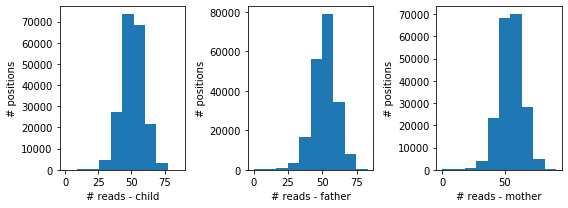

In [9]:
%pylab inline
import os
import numpy as np

def PlotCovDist(plot=False):
    # Compute these values and return below
    mean_child_cov = 0
    mean_father_cov = 0
    mean_mother_cov = 0
    
    # Load coverage info
    # In trio.mpileup:
    #   4th column: child coverage
    #   7th column: father coverage
    #   10th column: mother coverage
    cov_child = []
    cov_father = []
    cov_mother = []
    with open("/datasets/cs185-sp21-A00-public/week1/precomputed/trio.mpileup") as f:
        for line in f:
            items = line.strip().split() # split columns of each line on whitespace
            cov_child.append(int(items[3]))
            cov_father.append(int(items[6]))
            cov_mother.append(int(items[9]))
    
    # Plot coverage distributions
    if plot:
        fig = plt.figure()
        fig.set_size_inches((8, 3))
        ax = fig.add_subplot(131)
        ax.hist(cov_child)
        ax.set_xlabel("# reads - child")
        ax.set_ylabel("# positions")
        ax = fig.add_subplot(132)
        ax.hist(cov_father)
        ax.set_xlabel("# reads - father")
        ax.set_ylabel("# positions")
        ax = fig.add_subplot(133)
        ax.hist(cov_mother)
        ax.set_xlabel("# reads - mother")
        ax.set_ylabel("# positions")    
        fig.tight_layout();
    
    # Compute mean coverate of child, father, and mother.
    # Hint, see the example in plotting template 
    # length distribution at the end of Part 1.
    # YOUR CODE HERE
    mean_child_cov = np.mean(cov_child)
    mean_father_cov = np.mean(cov_father)
    mean_mother_cov = np.mean(cov_mother)

    # Print out results
    print("Mean child coverage: %d"%mean_child_cov)
    print("Mean father coverage: %d"%mean_father_cov)
    print("Mean mother coverage: %d"%mean_mother_cov)

    # Return results
    return mean_child_cov, mean_father_cov, mean_mother_cov

PlotCovDist(plot=True);

In [10]:
"""Check computed average coverages"""
mean_child_cov, mean_father_cov, mean_mother_cov = PlotCovDist(plot=False)
assert(int(mean_child_cov) + int(mean_father_cov)+int(mean_mother_cov) == 155)


Mean child coverage: 50
Mean father coverage: 51
Mean mother coverage: 54


## 3. Running a SNP caller (Varscan)

Now we will run a SNP caller to identify variants in our three samples. We could parse the mpileup file ourselves to do this, but there are already dozens of existing SNP callers out there so for now we'll choose not to reinvent the wheel.

Until now, all the programs you have been using (BWA, fastqc, samtools...) were pre-installed for you in our public folder. Here you’ll get to try your hand at installing one type of program file.

Use the command below (`curl` - it's a unix command to access websites) to download VarScan into your `week1` folder. Notice that we are redirecting the contents of the download into a .jar file.

```
curl -L https://sourceforge.net/projects/varscan/files/VarScan.v2.3.9.jar/download > VarScan.jar
```

Try to bring up the help message with:
```
java -jar VarScan.jar
```

This install method won’t be the same for all bioinformatics programs, and it might not even be the same for other Java programs, as installing open source software often has dependencies (prerequisite software) and can be sensitive to where its installed and how it is executed. We'll try to touch on this throughout the course, and you'll get a lot of experience with this for the final project.

On the VarScan man page, you should see several commands. We are interested in the `mpileup2snp` command. Go ahead and enter it with `-h` to bring up the manual.

```
java -jar VarScan.jar mpileup2snp -h
```

There are lots of ways we could filter our data. VarScan lets the user define their own cutoffs for including data in calling variants. Other programs rely on more complex statistical procedures to evaluate the likelihood of real mutations.

The first option we are interested in setting is the `--min-var-frequency` option. This sets the minimum % of non-reference bases at a position required to call it a variant in the sample. Set this too low, and we'll pick up mostly sequencing errors. Set this too high, and we'll miss real variants. We're also interested in `--min-freq-for-hom`, the minimum % of non-reference bases to call a variant homozygous.

We'll set those values to `--min-var-frequency 0.2 --min-freq-for-hom 0.8`. This means to even consider something to be a SNP, we'll require at least 20% of the reads to have non-reference alleles. To consider something as a homozygous non-reference SNP, we'll require at least 80% of the reads to have non-reference alleles.

**Question 4 (6 pts)**: Use the VarScan `mpileup2snp` command to genotype SNPs from our `trio.mpileup` file. Use options `--min-var-frequency 0.2 --min-freq-for-hom 0.8`, and set the p-value threshold to 0.01. Make VarScan output the resulting genotypes in VCF format, and only output variants (positions that don't match the reference genome). Direct the output to the file `trio.vcf`.

* Question 4.1 (2 pts): Set the variable `varscan_cmd` below to the command you used.
* Question 4.2 (2 pts): Paste the first two lines of the resulting VCF file `trio.vcf` to the variable `vcf_top2lines` below.
* Question 4.3 (2 pts): Set the variable `numvars` to the total number of variants reported by VarScan.


In [8]:
# Complete and run the following command
varscan_cmd = """
java -jar VarScan.jar mpileup2snp trio.mpileup --min-var-frequency 0.2 --min-freq-for-hom 0.8 --p-value 0.01 --output-vcf 1 --variants > trio.vcf
"""

# Paste the first two lines of trio.vcf here
vcf_top2lines = """
##fileformat=VCFv4.1
##source=VarScan2
"""

# Set to the number of variants found
numvars = 41

# YOUR CODE HERE
#raise NotImplementedError()

In [9]:
# Test the command is reasonable
assert("VarScan.jar" in varscan_cmd)
assert("--min-var-frequency" in varscan_cmd and "0.2" in varscan_cmd)
assert("--min-freq-for-hom" in varscan_cmd and "0.8" in varscan_cmd)
assert("--p-value" in varscan_cmd)
# Additional hidden tests


In [10]:
# Check value of top 2 lines
assert(len(vcf_top2lines.strip().split("\n"))==2)
assert("##fileformat=VCF" in vcf_top2lines)
assert("VarScan2" in vcf_top2lines)
# Hidden tests check actual value


In [11]:
# Check number of variants
assert(type(numvars) == int)
assert(numvars > 30)
assert(numvars < 50)
# Hidden tests check actual value


## 4. Intro to VCF files

VarScan outputs variants in VCF (variant call format), a standard genomics format. To read about all the gory details of VCF files, see the specs: https://samtools.github.io/hts-specs/VCFv4.2.pdf

First take a peak and scroll through the file:

```
cat trio.vcf | less -S
```

Key things to notice:

* The header lines (starting with "#") give general information about the file such as the tool use to generate it and a description of all the different data fields in the file.
* Below the header, there is one line per variant. For each variant, you can find the chromosome, position, reference allele, alternate allele, and additional info. Following these fields are the variant call and statistics for each sample
* "INFO" fields describe per-variant statistics. "FORMAT" fields describe per-sample statistics at each variant.

See lecture slides for more VCF info.

**Question 5 (6 pts)**: Look at the position chr6:128593590 (it might be helpful to use grep for this. See example command below). 

```
grep 128593590 trio.vcf
```

* Question 5.1 (1 pt): What is the reference allele at this position? Set the variable `ref_allele` below to your answer.
* Quesiton 5.2 (1 pt): What is the alternate allele at this position? Set the variable `alt_allele` below to your answer.
* Question 5.3 (2 pts): Set the variables `child_gt2`, `father_gt2`, and `mother_gt2` below to the genotype at each sample. (e.g. AC, TG, TT, etc.)
* Question 5.4 (2 pts): Set the variables `child_p`, `father_p`, and `mother_p` to the p-value for each sample. This p-value gives a measure of how confident we are the position is a SNP. Lower = more confident. More on p-values in a couple weeks.

In [35]:
ref_allele = "T"
alt_allele = "G"
child_gt2 = "TT"
father_gt2 = "TT"
mother_gt2 = "TG"
child_p = 1
father_p = 1
mother_p = 9.8643E-8

# YOUR CODE HERE
#raise NotImplementedError()

In [36]:
assert(ref_allele in ["A","C","G","T"])


In [37]:
assert(alt_allele in ["A","C","G","T"])


In [38]:
for gt in [child_gt2, father_gt2, mother_gt2]:
    assert(gt in ["GT","GG","TT","TG"])
    

In [39]:
for pval in [child_p, father_p, mother_p]:
    assert(float(pval)>=0 and float(pval)<=1)
assert 1.0 in [float(item) for item in [child_p, father_p, mother_p]]
    

## 5. Mutation identification and annotation

We'd now like to identify potential *de novo* mutations that occurred in the child genome but that were not passed down by either parent. 

**Question 6 (10 pts)** In the space below, write a small program that identifies candidate mutations in the child genome.

You may do this using whatever means you want, but example template code to get you started using the PyVCF library is provided. This can also be done using bash commands. Your code must run from within the notebook and output a list of candidate mutation positions.

The code prints out one line per position genotyped to give you an idea of how PyVCF works. Modify the code so that it returns a list of potential positions of de novo mutations. As in examples above, if `trio.vcf` is loaded below from our precomputed results.

In [68]:
# This code simply prints out each position in the VCF file and the genotypes
# of each sample. Modify to return a list of positions of potential de novo
# mutations. That is, positions where the child has an allele not seen in 
# either parent.

import vcf

# This code is using the PyVCF library to parse VCFs
# See more here: https://pyvcf.readthedocs.io/en/latest/INTRO.html
# You shouldn't have to deal directly with any PyVCF functions
# in your solution.

# Some Python functions you might find useful:
# split: https://www.w3schools.com/python/ref_string_split.asp
#    e.g. child_alleles = child_gt.split("/") 
# Checking if an item is in a list
#    e.g.:
#         alleles = ["A","A"]
#       "A" in alleles # returns True
#        "T" in alleles # returns False
# Appending to a list
#    e.g. positions.append(pos) adds pos to the list

def GetDenovoPositions(printpos=False):
    reader = vcf.Reader(open("/datasets/cs185-sp21-A00-public/week1/precomputed/trio.vcf", "r"))
    positions = [] # List of positions of potential de novo variants
    
    for record in reader:
        chrom  = record.CHROM # e.g. chr6
        pos = record.POS # e.g. 128414945
        
        # This assuming your mpileup file is in the order child, father, mother
        child_gt = record.genotype("Sample1").gt_bases # e.g. 'T/T'
        father_gt = record.genotype("Sample2").gt_bases # e.g. 'T/A'
        mother_gt = record.genotype("Sample3").gt_bases # e.g. 'T/T'

        # If the position is denovo, add pos to positions
        # YOUR CODE HERE
        child_alleles = child_gt.split("/")
        father_alleles = father_gt.split("/")
        mother_alleles = mother_gt.split("/")
        
        father_has_first = child_alleles[0] in father_alleles
        father_has_second = child_alleles[1] in father_alleles
        mother_has_first = child_alleles[0] in mother_alleles
        mother_has_second = child_alleles[1] in mother_alleles
        heterozygous = child_alleles[0] == child_alleles[1]
        
        #if child has SNP that neither parent has
        if (not father_has_first and not mother_has_first) or (not father_has_second and not mother_has_second):
            positions.append(pos)
      
        #if child has SNP where one parent couldn't have contributed either allele
        if (not father_has_first and not father_has_second) or (not mother_has_first and not mother_has_second):
            positions.append(pos)
    
        #raise NotImplementedError()
        if printpos:
            print("%s:%s:%s;%s;%s"%(chrom, pos, child_gt, father_gt, mother_gt))
        
    return positions

GetDenovoPositions(printpos=True)

chr6:128414945:T/T;T/T;T/T
chr6:128419307:T/A;T/A;T/A
chr6:128421762:T/T;T/T;T/T
chr6:128435303:C/T;C/T;C/T
chr6:128442104:G/G;G/G;G/T
chr6:128446509:T/T;T/T;T/T
chr6:128450019:T/G;T/G;T/T
chr6:128465668:C/T;C/C;C/T
chr6:128469937:T/A;T/A;T/A
chr6:128471913:A/C;A/C;A/C
chr6:128484504:A/G;A/G;A/A
chr6:128486139:A/C;A/C;A/C
chr6:128488195:T/C;T/C;T/C
chr6:128493991:G/T;G/T;G/T
chr6:128494093:C/G;C/G;C/G
chr6:128496528:T/T;T/T;T/C
chr6:128496557:T/T;T/T;T/T
chr6:128503550:T/C;T/C;T/T
chr6:128505804:A/C;A/A;A/A
chr6:128514053:G/A;G/A;G/A
chr6:128515718:T/C;T/C;T/T
chr6:128517169:T/T;T/T;T/C
chr6:128532763:G/C;G/C;G/C
chr6:128559329:C/T;C/T;C/T
chr6:128564669:G/T;G/T;G/T
chr6:128568999:C/T;C/T;C/C
chr6:128572877:C/A;C/A;C/A
chr6:128583972:G/A;G/G;G/A
chr6:128583983:T/G;T/T;T/G
chr6:128585618:A/C;A/C;A/C
chr6:128591818:T/G;T/G;G/G
chr6:128593590:T/T;T/T;T/G
chr6:128599580:C/A;C/A;C/A
chr6:128599902:A/A;A/A;A/A
chr6:128602090:A/C;A/C;A/C
chr6:128602577:T/C;T/C;T/C
chr6:128602796:C/T;C/T;C/T
c

[128505804]

In [69]:
# Check that the function runs and outputs a list
positions = GetDenovoPositions(printpos=False)
assert(type(positions)==list)

In [70]:
# Check that the length of positions is correct
positions = GetDenovoPositions(printpos=False)
assert(len(positions)>0 and len(positions)<100)


In [71]:
# Check that values in positions are reasonable
positions = GetDenovoPositions(printpos=False)
assert(type(positions[0] == int))

In [72]:
# Check actual positions in the list
positions = GetDenovoPositions(printpos=False)
assert(min(positions)>128414945)


Now let's figure out if the mutations identified are likely to have an impact on any particular genes. We'll use the UCSC Genome Browser (https://genome.ucsc.edu/) to help with this. Go to the genome browser home page. Then on the top menu bar, hover over "Genomes" and choose the hg19 reference genome. We'll post a short video tutorial to canvas on using the genome browser to help familiarize you with various features.

**Question 7 (6 pts)**: In the search bar, navigate to the position of each mutation. e.g. "chr6:XXXX" in the search bar. Does any mutation fall within a gene? If yes, determine whether it is predicted to change the amino acid structure (i.e. is this a synonymous variant? missense? nonsense?) of the protein and describe the change below. Make sure to determine which strand the gene is on! (forward vs. reverse)

You should find that one of your mutation(s) is predicted to alter the amino acid sequence of a protein.

* Question 7.1 (1 pt): Which genes does the mutation fall in?
* Question 7.2 (1 pt): What codon is at this position in the reference position?
* Question 7.3 (1 pt): What amino acid does that codon code for?
* Question 7.4 (1 pt): What does your mutation change the codon to?
* Question 7.5 (1 pt): What amino acid does the mutant codon code for?
* Question 7.6 (1 pt): What type of mutation is this? (missense, nonsense, or synonymous

Set your answers in the variables `q7_1`, `q7_2`, etc. below.

In [85]:
q7_1 = "PTPRK" # Which genes does the mutation fall in?
q7_2 = "CAA" # What codon is at this position in the reference position?
q7_3 = "Q" # What amino acid does that codon code for? Use 1 -letter code
q7_4 = "AGC" # What does your mutation change the codon to?
q7_5 = "S" # What amino acid does the mutant codon code for?
q7_6 = "missense" # What type of mutation is this? (missense, nonsense, or synonymous

# YOUR CODE HERE
#raise NotImplementedError()

In [86]:
assert(type(q7_1)==str)
assert(len(q7_1)==5)


In [87]:
nucs = ["A","C","G","U"]
codon_table = []
for i in nucs:
    for j in nucs:
        for k in nucs:
            codon_table.append(i+j+k)
assert(q7_2 in codon_table)
assert(q7_2.startswith("C"))

In [88]:
amino_acids = ["A","R","N","D","B","C","E","Q","Z","G","H","I","L","K","M","F","P","S","T","W","Y","V"]
assert(q7_3 in amino_acids)

In [89]:
assert(q7_4 in codon_table)
assert(q7_4.startswith("C"))
assert(q7_4 != q7_2)

AssertionError: 

In [90]:
assert(q7_5 in amino_acids)

In [91]:
assert(q7_6 in ["missense","nonsense","nonsynonymous"])

# 6. Additional  questions

**Question 8 (3 pts)**: You sequenced the genome of a patient in your clinic with a suspected neurodevelopmental disorder and plotted the distribution of coverage across all bases of the genome. The mean coverage is around 40x, with most bases covered between 20-60 times. However you notice some bases are never covered (0 coverage) and other bases have extremely large coverages (1000x). What could be happening at positions with extremely low or high coverage?

A. Bases with 0 coverage may represent repeats that we cannot map uniquely to
B. Bases with 0 coverage may represent places that are very difficult to sequence (e.g. very high GC content).
C. Positions with very high coverage are likely repeats (e.g. centromeres, telomeres, Alu/LINE).
D. Positions with low coverage likely represent regions with close to 50% GC content in highly mappable regions.
E. A, B, and C, are possible.
F. A, B, C, and D are possible.

Set the variable `q8` below to your answer.

In [93]:
q8 = "E" # Set to A, B, C, D, E, or F
# YOUR CODE HERE
#raise NotImplementedError()

In [94]:
assert(q8 in ["A","B","C","D","E","F"])

**Question 9 (4 pts)**: For the same individual's genome, you plot the template length distribution (similar to how we did at the end of Part 1 of this lab.) If you plot the distribution over the entire genome, you see a mean template length of around 300bp. However, when you zoom in on a particular region of the genome, you see many read pairs with template lengths closer to 600bp. What could explain this?

A. An insertion of 600bp compared to the reference genome
B. An insertion of 300bp compared to the reference genome
C. A deletion of 300bp compared to the reference genome.
D. A deletion of 600bp compared to the reference genome.

Set the variable `q9` below to your answer.

In [96]:
q9 = "C"
# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
assert(q9 in ["A","B","C","D"])

**Question 10 (4 pts)**: You are sequencing the genome of a tetraploid genome (4 copies of the genome, rather than 2 like diploid humans). At a position with 30x coverage where only one of the four copies of the genome contains a variant from the reference genome, how many reads do you expect on average to have the variant? Set the variable `q10` below to your answer.

In [97]:
q10 = 7.5 # Set to your answer.
# YOUR CODE HERE
#raise NotImplementedError()

In [98]:
assert(type(q10)==float)
assert(q10>0 and q10<=30)

## 7. Submit the assignment!

Under the "Assignment" tab in JupyterHub, for the Lab1 assignment you should see buttons:

* Validate: lets you check if your notebooks are passing all visible tests.
* Submit: will submit your assignment!